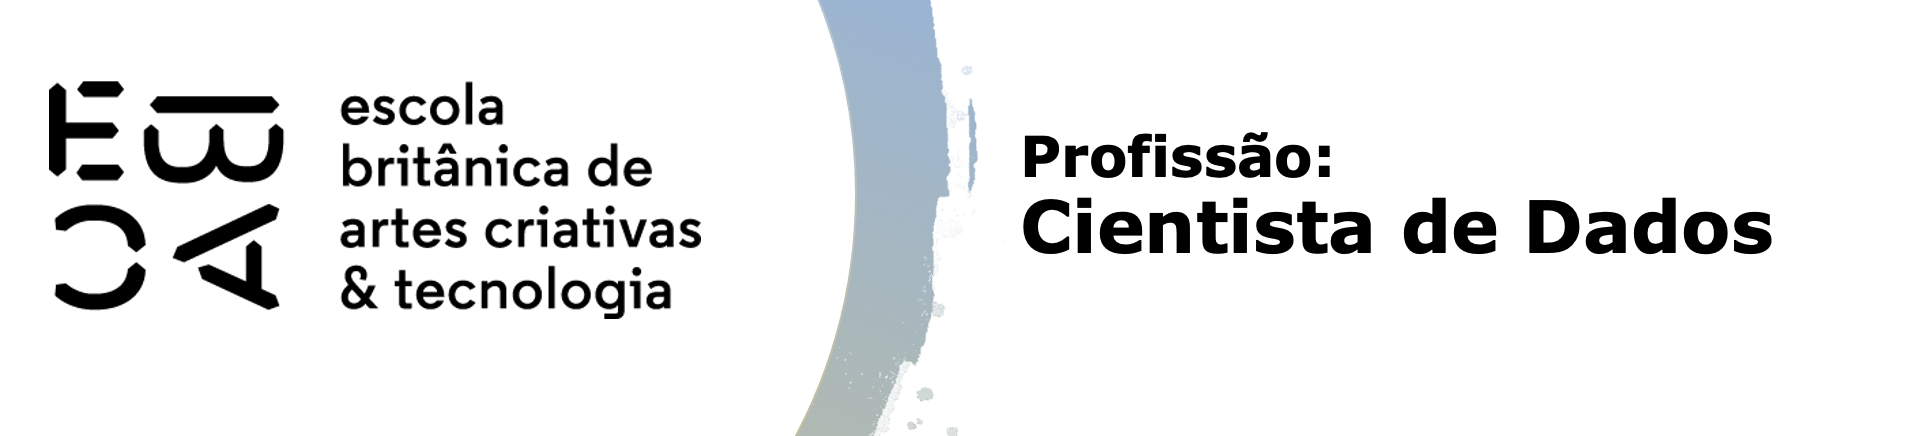

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline

In [2]:
features = pd.read_csv("./Dataset/features.txt", sep="\s+", header=None, names=["index","feature_name"])

# Treino
subject_train = pd.read_csv("./Dataset/train/subject_train.txt", header=None, names=["subject"])
X_train_full = pd.read_csv("./Dataset/train/X_train.txt", sep="\s+", header=None)
y_train = pd.read_csv("./Dataset/train/y_train.txt", header=None, names=["activity"])

# Teste
subject_test = pd.read_csv("./Dataset/test/subject_test.txt", header=None, names=["subject"])
X_test_full = pd.read_csv("./Dataset/test/X_test.txt", sep="\s+", header=None)
y_test = pd.read_csv("./Dataset/test/y_test.txt", header=None, names=["activity"])

# Nomear colunas
X_train_full.columns = features["feature_name"]
X_test_full.columns = features["feature_name"]

# adicionar sujeito e activity por posição (para evitar desalinhamento)
X_train_full["subject"] = subject_train["subject"].values
X_train_full["activity"] = y_train["activity"].values

X_test_full["subject"] = subject_test["subject"].values
X_test_full["activity"] = y_test["activity"].values

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [3]:
# Criando conjuntos reduzidos (apenas para visualização / debug)
# mas para seleção de importâncias usamos todas features (sem subject/activity)
# Preparar X (todas as features sem subject/activity) e y como Series
X_train_all = X_train_full.drop(columns=["subject", "activity"])
y_train_series = y_train["activity"]            # Series
X_test_all = X_test_full.drop(columns=["subject", "activity"])
y_test_series = y_test["activity"]              # Series

print("X_train_all.shape:", X_train_all.shape)
print("X_test_all.shape:", X_test_all.shape)

X_train_all.shape: (7352, 561)
X_test_all.shape: (2947, 561)


In [4]:
# Treinando a árvore inicial (min_samples_leaf=20) para obter importâncias

clf_init = DecisionTreeClassifier(min_samples_leaf=20, random_state=1729)
clf_init.fit(X_train_all, y_train_series)

importancias = pd.Series(clf_init.feature_importances_, index=X_train_all.columns)
importancias_ordenadas = importancias.sort_values(ascending=False)
top3 = importancias_ordenadas.head(3)
print("\nTop 3 variáveis (todas as features):")
print(top3)

# usando as 3 variáveis
melhores_variaveis = top3.index.tolist()
print("\nMelhores variáveis selecionadas:", melhores_variaveis)


Top 3 variáveis (todas as features):
feature_name
tGravityAcc-min()-X     0.257561
fBodyAcc-mean()-X       0.216113
angle(Y,gravityMean)    0.145896
dtype: float64

Melhores variáveis selecionadas: ['tGravityAcc-min()-X', 'fBodyAcc-mean()-X', 'angle(Y,gravityMean)']


In [5]:
# Preparan dados apenas com top3
X_train_top3 = X_train_all[melhores_variaveis]
X_test_top3  = X_test_all[melhores_variaveis]

# Calculndo ccp_alphas e reduzir a grade (usar apenas >0 e valores únicos)
path = DecisionTreeClassifier(min_samples_leaf=20, random_state=1729).cost_complexity_pruning_path(X_train_top3, y_train_series)
ccp_all = path.ccp_alphas
# mantendo >0 e únicos
ccp_pos = np.unique(ccp_all[ccp_all > 0])

# reduzindo varredura: 1 a cada 10 (ajuste conforme tempo)
ccp_sampled = ccp_pos[::10]
if len(ccp_sampled) == 0:  # fallback se ficou vazio
    ccp_sampled = ccp_pos

print("\nNúmero de alphas originais:", len(ccp_pos))
print("Número de alphas usados (amostrados):", len(ccp_sampled))


Número de alphas originais: 105
Número de alphas usados (amostrados): 11


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [6]:
# 6) GridSearchCV (k-fold = 10) medindo tempo
param_grid = {"ccp_alpha": ccp_sampled}
est = DecisionTreeClassifier(min_samples_leaf=20, random_state=1729)

grid = GridSearchCV(estimator=est, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

start = time.time()
grid.fit(X_train_top3, y_train_series)
end = time.time()
print(f"\nGridSearchCV completo em {end-start:.1f} segundos")

# resultados
print("\nMelhor parâmetro encontrado:", grid.best_params_)
print("Melhor score (cv):", grid.best_score_)

Fitting 10 folds for each of 11 candidates, totalling 110 fits

GridSearchCV completo em 6.9 segundos

Melhor parâmetro encontrado: {'ccp_alpha': np.float64(0.0024277232304312597)}
Melhor score (cv): 0.7877918884945283


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão


Acurácia no teste: 0.7170


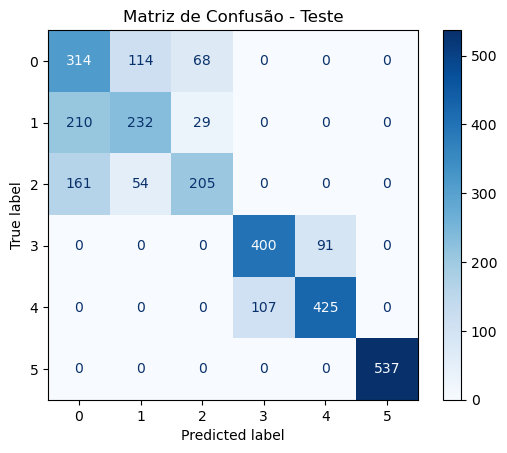

In [7]:
# Treinando modelo final com melhor alpha em toda a base de treino
best_alpha = grid.best_params_["ccp_alpha"]
clf_final = DecisionTreeClassifier(min_samples_leaf=20, random_state=1729, ccp_alpha=best_alpha)
clf_final.fit(X_train_top3, y_train_series)

# Avaliação em teste
y_pred_test = clf_final.predict(X_test_top3)
acc_test = accuracy_score(y_test_series, y_pred_test)
print(f"\nAcurácia no teste: {acc_test:.4f}")

cm = confusion_matrix(y_test_series, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Teste")
plt.show()

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [8]:
# Verificação mínimas (variáveis que precisamos existir após seus passos anteriores)
needed = ["X_train_all", "X_test_all", "y_train_series", "y_test_series", "melhores_variaveis"]
missing = [n for n in needed if n not in globals()]
if missing:
    raise RuntimeError(f"Faltam variáveis no ambiente: {missing}. Rode os blocos anteriores que criam X_train_all, X_test_all, y_train_series, y_test_series e melhores_variaveis.")

# Escolhendo um classificador já treinado para identificar os erros no teste
clf_used = None
if "grid" in globals() and hasattr(globals()["grid"], "best_estimator_"):
    clf_used = globals()["grid"].best_estimator_
elif "clf_final" in globals():
    clf_used = globals()["clf_final"]
elif "clf_init" in globals():
    clf_used = globals()["clf_init"]
elif "clf" in globals():
    clf_used = globals()["clf"]
else:
    # fallback: treinando rápido com as 3 melhores variáveis (se nada existir)
    print("Nenhum classificador existente encontrado — vou treinar um classificador simples com as 'melhores_variaveis' para identificar classes difíceis.")
    clf_used = DecisionTreeClassifier(min_samples_leaf=20, random_state=1729)
    clf_used.fit(X_train_all[melhores_variaveis], y_train_series)

print("Classificador usado para detectar erros:", clf_used)

Classificador usado para detectar erros: DecisionTreeClassifier(ccp_alpha=np.float64(0.0024277232304312597),
                       min_samples_leaf=20, random_state=1729)


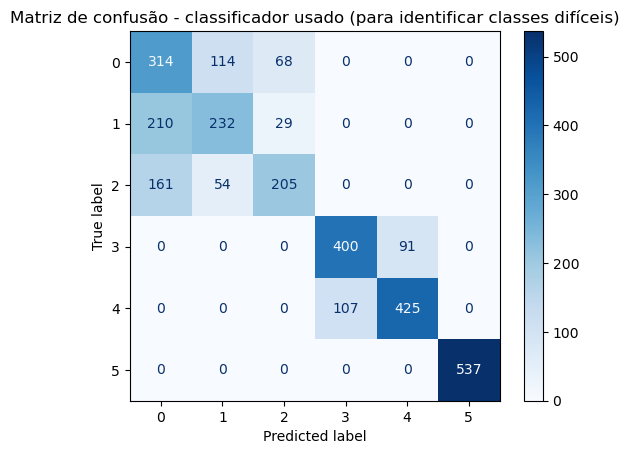

In [9]:
# Previsões no teste usando as mesmas colunas que o classificador espera
# Tentamos descobrir as colunas usadas pelo classificador (se possível)
try:
    # se o classificador foi treinado com X_train_top3, use essas colunas
    # geralmente temos X_test_top3 já definido; caso contrário, usamos melhores_variaveis
    if "X_test_top3" in globals():
        X_for_pred = X_test_top3
    else:
        X_for_pred = X_test_all[melhores_variaveis]
except Exception:
    X_for_pred = X_test_all[melhores_variaveis]

y_pred_used = clf_used.predict(X_for_pred)

# Matriz de confusão do classificador usado
cm0 = confusion_matrix(y_test_series, y_pred_used)
disp0 = ConfusionMatrixDisplay(confusion_matrix=cm0)
disp0.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusão - classificador usado (para identificar classes difíceis)")
plt.show()

In [10]:
# Calculando taxa de erro por classe e escolher a classe "mais difícil"
df_err = pd.DataFrame({"y_true": y_test_series.values.flatten(), "y_pred": y_pred_used})
df_err["erro"] = (df_err["y_true"] != df_err["y_pred"]).astype(int)
erro_por_classe = df_err.groupby("y_true")["erro"].mean().sort_values(ascending=False)
print("\nTaxa de erro por classe (decrescente):")
print(erro_por_classe)

classe_dificil = erro_por_classe.index[0]
print(f"\nClasse mais difícil identificada: {classe_dificil}")


Taxa de erro por classe (decrescente):
y_true
3    0.511905
2    0.507431
1    0.366935
5    0.201128
4    0.185336
6    0.000000
Name: erro, dtype: float64

Classe mais difícil identificada: 3


In [11]:
# Criando variável binária 'is_dificil' em cópias dos conjuntos (usando y_train_series/y_test_series)
X_train_bin = X_train_all.copy()
X_test_bin  = X_test_all.copy()

# Garantindo que y_train_series e y_test_series são Series alinhadas por posição
y_train_s = pd.Series(y_train_series.values.flatten(), index=X_train_bin.index)
y_test_s  = pd.Series(y_test_series.values.flatten(), index=X_test_bin.index)

X_train_bin["is_dificil"] = (y_train_s == classe_dificil).astype(int).values
X_test_bin["is_dificil"]  = (y_test_s  == classe_dificil).astype(int).values

print("\nDistribuição da nova variável is_dificil (treino):")
print(X_train_bin["is_dificil"].value_counts())


Distribuição da nova variável is_dificil (treino):
is_dificil
0    6366
1     986
Name: count, dtype: int64



Top 3 variáveis que ajudam a identificar a classe difícil:
feature_name
tBodyAcc-max()-X               0.775057
tBodyGyro-correlation()-Y,Z    0.051200
fBodyAccMag-mad()              0.036257
dtype: float64


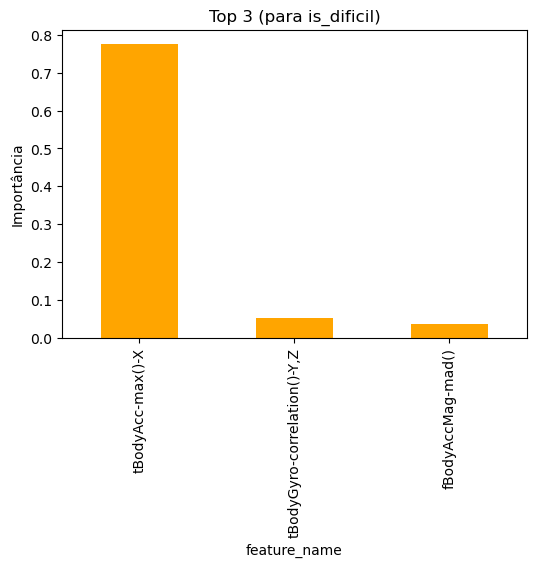

In [12]:
# Treinando árvore simples para prever is_dificil usando TODAS as features
# Removendo colunas não-features caso existam (subject/activity)
cols_drop = [c for c in ["subject", "activity"] if c in X_train_bin.columns]
X_bin_train = X_train_bin.drop(columns=cols_drop + ["is_dificil"], errors="ignore")
y_bin_train = X_train_bin["is_dificil"]

clf_bin = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=1729)
clf_bin.fit(X_bin_train, y_bin_train)

# Importâncias e top3 novas variáveis
importancias_bin = pd.Series(clf_bin.feature_importances_, index=X_bin_train.columns)
importancias_bin_ordenadas = importancias_bin.sort_values(ascending=False)
top3_novas = importancias_bin_ordenadas.head(3)
print("\nTop 3 variáveis que ajudam a identificar a classe difícil:")
print(top3_novas)

plt.figure(figsize=(6,4))
top3_novas.plot(kind="bar", color="orange")
plt.title("Top 3 (para is_dificil)")
plt.ylabel("Importância")
plt.show()

In [13]:
# Combinando: 3 antigas + 3 novas (evitar duplicatas), treinar e avaliar
novas = list(top3_novas.index)
originais = list(melhores_variaveis)
variaveis_finais = list(dict.fromkeys(originais + novas))  # mantém ordem sem duplicar
print("\nVariáveis finais usadas no modelo principal:", variaveis_finais)

X_train_final = X_train_all[variaveis_finais]
X_test_final  = X_test_all[variaveis_finais]


Variáveis finais usadas no modelo principal: ['tGravityAcc-min()-X', 'fBodyAcc-mean()-X', 'angle(Y,gravityMean)', 'tBodyAcc-max()-X', 'tBodyGyro-correlation()-Y,Z', 'fBodyAccMag-mad()']


In [14]:
# Usando melhor ccp_alpha se estiver disponível no ambiente (grid.best_params_, best_alpha, melhor_ccp)
ccp_val = None
if "best_alpha" in globals():
    ccp_val = globals()["best_alpha"]
elif "melhor_ccp" in globals():
    ccp_val = globals()["melhor_ccp"]
elif "grid" in globals() and hasattr(globals()["grid"], "best_params_") and "ccp_alpha" in globals()["grid"].best_params_:
    ccp_val = globals()["grid"].best_params_["ccp_alpha"]

if ccp_val is not None:
    print(f"\nUsando ccp_alpha previamente encontrado: {ccp_val:.6g}")
    clf_final2 = DecisionTreeClassifier(min_samples_leaf=20, random_state=1729, ccp_alpha=ccp_val)
else:
    print("\nNenhum ccp_alpha reaproveitável encontrado — treinando sem poda.")
    clf_final2 = DecisionTreeClassifier(min_samples_leaf=20, random_state=1729)

clf_final2.fit(X_train_final, y_train_s)

y_pred_final = clf_final2.predict(X_test_final)
acc_final = accuracy_score(y_test_s, y_pred_final)
print(f"\nAcurácia final (com variáveis extra): {acc_final:.4f}")


Usando ccp_alpha previamente encontrado: 0.00242772

Acurácia final (com variáveis extra): 0.7849


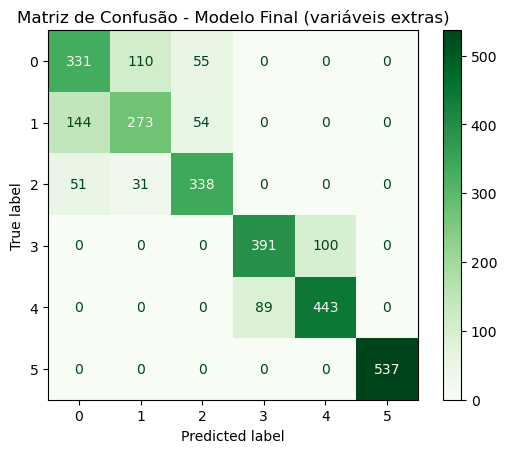

In [15]:
# Matriz de confusão final
cmf = confusion_matrix(y_test_s, y_pred_final)
disp_f = ConfusionMatrixDisplay(confusion_matrix=cmf)
disp_f.plot(cmap="Greens", values_format="d")
plt.title("Matriz de Confusão - Modelo Final (variáveis extras)")
plt.show()

In [16]:
# Comparando com o modelo original
acc_original = None
try:
    # Se já tínhamos uma previsão y_pred_used e y_test_series, calculamos
    acc_original = accuracy_score(y_test_series, y_pred_used)
    print(f"\nAcurácia do modelo usado para detectar a classe difícil: {acc_original:.4f}")
    ganho = acc_final - acc_original
    print(f"Ganho absoluto na acurácia: {ganho:.4f} ({ganho*100:.2f} pontos percentuais)")
except Exception:
    pass


Acurácia do modelo usado para detectar a classe difícil: 0.7170
Ganho absoluto na acurácia: 0.0679 (6.79 pontos percentuais)
